In [176]:
import numpy as np
import torch
from losses import EnergyScore, KernelScore
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

device="cuda" if torch.cuda.is_available() else "cpu"

In [177]:
x_train, y_train = make_moons(n_samples=1000, noise=0.1)
x_test, y_test = make_moons(n_samples=100, noise=0.1)

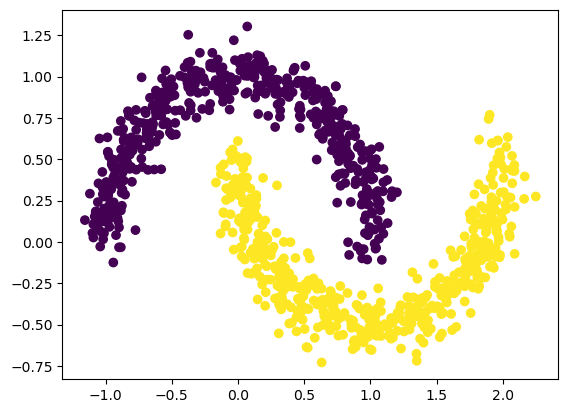

In [178]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

# Network

In [179]:
class TwoMoons(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.X = torch.from_numpy(x_data).to(device)
        self.Y = torch.from_numpy(y_data).to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

In [180]:
# Three layer fully connected neural network
class MLP(torch.nn.Module):
    def __init__(self, n_samples = 5):
        super(MLP, self).__init__()
        self.n_samples = n_samples
        self.fc1 = torch.nn.Linear(2, 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.mu = torch.nn.Linear(50, 1)
        self.sigma = torch.nn.Linear(50, 1)

    def forward(self, x, n_samples = None):
        if n_samples is not None:
            self.n_samples = n_samples
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        # Reparametrization
        y = self.mu(x) + torch.nn.functional.softplus(self.sigma(x)) * torch.randn(x.shape[0], self.n_samples).to(device)
        # Classification output
        y = torch.sigmoid(y)
        return y

In [181]:
# Create the training data as a DataLoader Object
two_moons_train = TwoMoons(x_train, y_train)
train_data = torch.utils.data.DataLoader(two_moons_train, batch_size=100)
two_moons_test = TwoMoons(x_test, y_test)
test_data = torch.utils.data.DataLoader(two_moons_test, batch_size=100)

In [182]:
# Create model
model = MLP(n_samples = 5).to(device)
loss_function = KernelScore(d = 1, type = "p")
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

In [183]:
# 1. Initialization
num_epochs = 30

torch.manual_seed(42)

loss_history = np.zeros((num_epochs))
accuracy_history = np.zeros((num_epochs))

initial_preds = model(two_moons_train.X.float()).unsqueeze(1)
initial_loss = loss_function(initial_preds, two_moons_train.Y.unsqueeze(1).float())
initial_acc = torch.eq(initial_preds.mean(axis = -1).squeeze(1).round().bool(), two_moons_train.Y.bool()).sum()

print(f"Initial Loss: {initial_loss}")
print(f"Initial Accuracy: {initial_acc/len(two_moons_train)} \n")

#2. Learning
for epoch in range(num_epochs):
    running_loss = 0
    num_correct = 0
    total_samples = 0
    for i, (inputs, targets) in enumerate(train_data):
        optimizer.zero_grad()
        predictions = model(inputs.float()).unsqueeze(1)
        loss = loss_function(predictions, targets.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_correct += torch.eq(predictions.mean(axis = -1).squeeze(1).round().bool(),
                                targets.bool()).sum()
        total_samples += targets.size(0)

    loss_history[epoch] = running_loss/len(train_data)
    accuracy_history[epoch] = num_correct/total_samples

    print(
        f"Epoch: {epoch+1:02d}/{num_epochs} | Loss: {loss_history[epoch]:.5f} \t | Accuracy: {accuracy_history[epoch]:.5f}")



Initial Loss: -0.4391550123691559
Initial Accuracy: 0.47099998593330383 

Epoch: 01/30 | Loss: -0.44089 	 | Accuracy: 0.51600
Epoch: 02/30 | Loss: -0.44754 	 | Accuracy: 0.64600
Epoch: 03/30 | Loss: -0.45407 	 | Accuracy: 0.72700
Epoch: 04/30 | Loss: -0.46224 	 | Accuracy: 0.79800
Epoch: 05/30 | Loss: -0.46814 	 | Accuracy: 0.82300
Epoch: 06/30 | Loss: -0.47271 	 | Accuracy: 0.82800
Epoch: 07/30 | Loss: -0.47542 	 | Accuracy: 0.83700
Epoch: 08/30 | Loss: -0.47780 	 | Accuracy: 0.86200
Epoch: 09/30 | Loss: -0.47944 	 | Accuracy: 0.87500
Epoch: 10/30 | Loss: -0.48087 	 | Accuracy: 0.87900
Epoch: 11/30 | Loss: -0.48176 	 | Accuracy: 0.88700
Epoch: 12/30 | Loss: -0.48294 	 | Accuracy: 0.89900
Epoch: 13/30 | Loss: -0.48292 	 | Accuracy: 0.90200
Epoch: 14/30 | Loss: -0.48378 	 | Accuracy: 0.90200
Epoch: 15/30 | Loss: -0.48400 	 | Accuracy: 0.91100
Epoch: 16/30 | Loss: -0.48444 	 | Accuracy: 0.90400
Epoch: 17/30 | Loss: -0.48512 	 | Accuracy: 0.91300
Epoch: 18/30 | Loss: -0.48529 	 | Accuracy

# Plot decision boundary

Text(0.5, 1.0, 'Two Moons Dataset - Learned Decision Boundary')

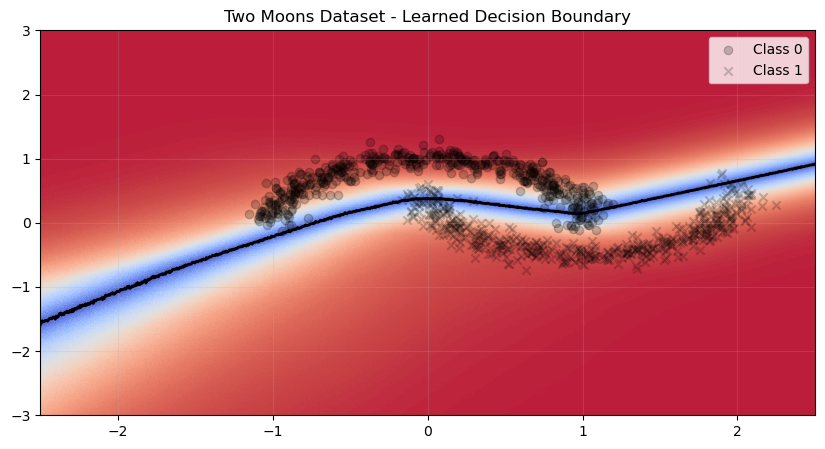

In [184]:
# Plot the scatter plot and the decision boundary
n_samples = 500
n_grid = 1000
x0_grid = np.linspace(-2.5, 2.5, num=n_grid)
x1_grid = np.linspace(-3, 3, num=n_grid)

pred_grid = torch.from_numpy(np.array(np.meshgrid(x0_grid, x1_grid)))
pred_grid = pred_grid.to(device)
pred_array = torch.transpose(
    torch.reshape(pred_grid, (2, pred_grid.shape[1]*pred_grid.shape[2])), 0, 1
)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
prediction = model(pred_array.float(), n_samples = n_samples).cpu().detach().numpy().reshape(n_grid,n_grid, n_samples)
pred_grid = pred_grid.cpu().detach().numpy()

# Plot colormesh
#uncertainty = pred
axs.pcolormesh(pred_grid[0], pred_grid[1], np.abs(prediction.mean(axis = -1)-0.5), cmap="coolwarm", alpha=0.9, vmin = 0, vmax = 0.5)

# Plot decision boundary
y_boundary = np.argmin(np.abs(np.mean(prediction, axis = -1)-0.5), axis = 0)
axs.plot(pred_grid[0, 0,:], pred_grid[1, y_boundary, 0], color="black", linewidth=2)

# Plot the data again
class_markers= ["o", "x"]
for i in range(len(np.unique(y_test))):
    axs.scatter(
        x_train[y_train == i, 0],
        x_train[y_train == i, 1],
        color="black",
        marker = class_markers[i],
        alpha=0.2,
        label="Class "+str(i)
    )

axs.grid(alpha=0.2)
axs.legend()
axs.set_title("Two Moons Dataset - Learned Decision Boundary")

